## MODEL USING HISTOGRAM


In [1]:
import os
import time
import numpy as np
import io
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [5]:
def extract_color_features(image, bins=10):
    lab_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2LAB)
    lightness, a_channel, b_channel = lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2]

    lightness = lightness / 255.0
    a_channel = (a_channel + 128) / 255.0 
    b_channel = (b_channel + 128) / 255.0

    lightness_hist = np.histogram(lightness, bins=bins, range=(0, 1), density=True)[0]
    a_hist = np.histogram(a_channel, bins=bins, range=(0, 1), density=True)[0]
    b_hist = np.histogram(b_channel, bins=bins, range=(0, 1), density=True)[0]
    
    feature_vector = np.concatenate([lightness_hist, a_hist, b_hist])
    
    return feature_vector

def load_images_and_labels(folder, label, bins=10):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(image_path))
        color_features = extract_color_features(image, bins)
        images.append(color_features.reshape(1, -1))
    labels = [label] * len(images)
    return np.vstack(images), np.array(labels)

# Load dataset
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels(
    "./Jaundiced Class/train", 1
    #"./train/train J", 1
    )
train_healthy_images, train_healthy_labels = load_images_and_labels(
    "./Normal Class/train", 0
    #"./train/train N", 0
    )

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))

X_train, y_train = shuffle(X_train, y_train, random_state=1)

test_jaundiced_images, test_jaundiced_labels = load_images_and_labels(
    "./Jaundiced Class/test", 1
    #"./test/test J", 1
    )
test_healthy_images, test_healthy_labels = load_images_and_labels(
    "./Normal Class/test", 0
    #"./test/test N", 0
    )

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))

val_jaundiced_images, val_jaundiced_labels = load_images_and_labels(
    "./Jaundiced Class/validate", 1
    #"./validate/validate J", 1
    )
val_healthy_images, val_healthy_labels = load_images_and_labels(
    "./Normal Class/validate", 0
    #"./validate/validate N", 0
    )

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

# Print dataset details for debugging
print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:5])


Test data shape: (18, 30)
Validation data shape: (38, 30)
Jaundiced images shape: (57, 30)
Healthy images shape: (71, 30)
X_train shape: (128, 30)
X_train dtype: float64
First 5 rows of X_train: [[3.66500e-01 7.10750e-01 1.05750e+00 9.99250e-01 2.14900e+00 2.47800e+00
  2.04900e+00 1.85750e-01 4.25000e-03 0.00000e+00 6.27250e+00 2.50000e-02
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 3.70250e+00 6.38300e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 3.61700e+00]
 [6.47500e-02 1.49000e-01 4.67000e-01 5.65250e-01 5.66750e-01 7.04250e-01
  1.03575e+00 4.98475e+00 1.41275e+00 4.97500e-02 9.67825e+00 2.27750e-01
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 9.40000e-02 7.71125e+00 2.27975e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 9.00000e-03]
 [1.07000e-01 1.31250e-01 1.21500e-01 2.61000e-01 8.43500e-01 9

In [6]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (128, 30)
X_test shape: (18, 30)
X_val shape: (38, 30)


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [9]:
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Binary classification
])

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks Early Stopping and Reduce LR on Plateau
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

elapsed_time = time.time() - start_time

# Evaluate Model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
stopped_epoch = early_stopping.stopped_epoch

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")
print(f"Training stopped at Epoch: {stopped_epoch}, Time Taken: {elapsed_time:.2f} sec")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9220 - loss: 1.2476 - precision_10: 0.8838 - recall_10: 0.9435 - val_accuracy: 0.7632 - val_loss: 1.8859 - val_precision_10: 0.7500 - val_recall_10: 0.7059 - learning_rate: 5.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8871 - loss: 1.5150 - precision_10: 0.8625 - recall_10: 0.8746 - val_accuracy: 0.7105 - val_loss: 2.0616 - val_precision_10: 0.6875 - val_recall_10: 0.6471 - learning_rate: 5.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8601 - loss: 1.3545 - precision_10: 0.8142 - recall_10: 0.8638 - val_accuracy: 0.7632 - val_loss: 1.7464 - val_precision_10: 0.7500 - val_recall_10: 0.7059 - learning_rate: 5.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9224 - loss: 1.1960 - precision_10: 0.8695 - recall_10: 0.9548 - val_accuracy: 0.7895 - val_loss: 2.0482 - val_precision_10: 0.7647 - val_recall_10: 0.7647 - learning_rate: 5.0000e-04
Epoch 5

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       1.00      0.98      0.99        55

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



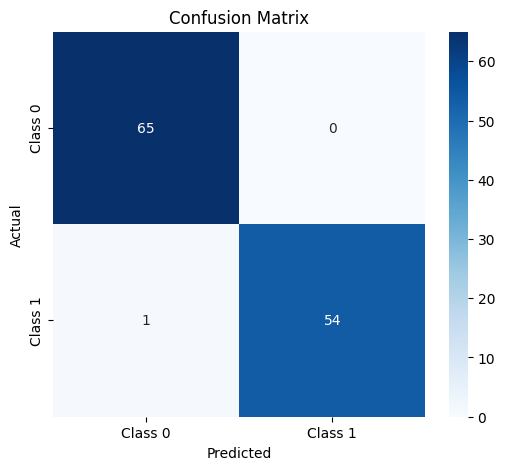

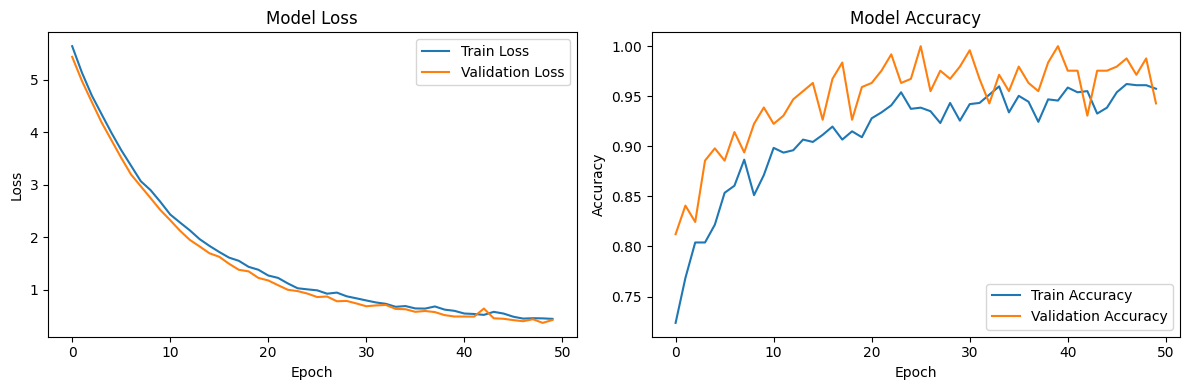

In [9]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.save("./releases/Jaundice_Classifier_HistogramV1.2.keras") 